# Initialize Notebook

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
import ROOT
import uproot
import os
import sys
import tqdm
import pandas as pd

%jsroot on
# %matplotlib qt
%matplotlib inline

Welcome to JupyROOT 6.30/00


In [2]:
from filterMethods import *
from reconstructionMethods import *
from statisticsMethods import *

In [3]:
os.environ['PATH'] = '/Library/TeX/texbin:' + os.environ['PATH']
mpl.rc('font', **{'family':'serif', 'serif':['Computer Modern Roman']})
params = {'backend': 'pdf',
          'axes.labelsize': 20,
          'font.size': 20,
          'legend.fontsize': 20,
          'xtick.labelsize': 20,
          'ytick.labelsize': 20,
          'text.usetex': True,
          'figure.figsize': (5,5),
          'axes.unicode_minus': True}
mpl.rcParams.update(params)

# Load Data

In [4]:
# file_input_name = '../runs/calibration/calibration_-0.85000_-0.85000_-0.85000.root'
# file_input_name = '../runs/calibration/calibration_-0.85000_-0.85000_-0.85000.root'
# file_input_name = '../runs/output_NEST_e-_1MeV.root'
file_input_name = '../build/event_total.root'
# file_input_name = '../build/event.root'
histogram_directory = 'photoSensor_hits_histograms'
file_input_pyroot = ROOT.TFile(file_input_name)
file_input_uproot = uproot.open(file_input_name)

histogram_names = [name for name in file_input_uproot.keys() if "/photoSensor_" in name]
print(histogram_names)

histogram_titles = [file_input_pyroot.Get(name).GetTitle() for name in histogram_names]
print(histogram_titles)

histogram_positions = [(float(title.split('_')[2]), float(title.split('_')[3]), float(title.split('_')[4])) for title in histogram_titles]
print(histogram_positions)

histogram_wall = [title.split('_')[1] for title in histogram_titles]
print(histogram_wall)

tree_names = [name for name in file_input_uproot.keys() if histogram_directory not in name]
print(tree_names)

['photoSensor_hits_histograms/photoSensor_0;1', 'photoSensor_hits_histograms/photoSensor_1;1', 'photoSensor_hits_histograms/photoSensor_2;1', 'photoSensor_hits_histograms/photoSensor_3;1', 'photoSensor_hits_histograms/photoSensor_4;1', 'photoSensor_hits_histograms/photoSensor_5;1', 'photoSensor_hits_histograms/photoSensor_6;1', 'photoSensor_hits_histograms/photoSensor_7;1', 'photoSensor_hits_histograms/photoSensor_8;1', 'photoSensor_hits_histograms/photoSensor_9;1', 'photoSensor_hits_histograms/photoSensor_10;1', 'photoSensor_hits_histograms/photoSensor_11;1', 'photoSensor_hits_histograms/photoSensor_12;1', 'photoSensor_hits_histograms/photoSensor_13;1', 'photoSensor_hits_histograms/photoSensor_14;1', 'photoSensor_hits_histograms/photoSensor_15;1', 'photoSensor_hits_histograms/photoSensor_16;1', 'photoSensor_hits_histograms/photoSensor_17;1', 'photoSensor_hits_histograms/photoSensor_18;1', 'photoSensor_hits_histograms/photoSensor_19;1', 'photoSensor_hits_histograms/photoSensor_20;1', '

In [5]:
tree = file_input_uproot['photoSensor_hits;1']

position_relative_x = tree['photoSensor_hits_position_relative_x'].array()
position_relative_y = tree['photoSensor_hits_position_relative_y'].array()

histogram = file_input_pyroot.Get(histogram_names[0])
n_bins_x = histogram.GetNbinsX()
n_bins_y = histogram.GetNbinsY()
values = np.zeros((n_bins_x, n_bins_y))
x_edges = []
y_edges = []
for i in range(1, n_bins_x + 2):
    x_edges.append(histogram.GetXaxis().GetBinLowEdge(i))
for i in range(1, n_bins_y + 2):
    y_edges.append(histogram.GetYaxis().GetBinLowEdge(i))
x_edges[ 0] -= 1e-9
y_edges[ 0] -= 1e-9
x_edges[-1] += 1e-9
y_edges[-1] += 1e-9

position_relative_x_bins = pd.Series(pd.cut(np.array(position_relative_x), bins=x_edges, retbins=False))
position_relative_y_bins = pd.Series(pd.cut(np.array(position_relative_y), bins=y_edges, retbins=False))
position_relative_x_binned = position_relative_x_bins.apply(lambda x: (x.right + x.left) / 2)
position_relative_y_binned = position_relative_y_bins.apply(lambda x: (x.right + x.left) / 2)
position_relative_x_nBin = position_relative_x_bins.cat.codes
position_relative_y_nBin = position_relative_y_bins.cat.codes

position_initial_x = tree['photoSensor_hits_position_initial_x'].array()
position_initial_y = tree['photoSensor_hits_position_initial_y'].array()
position_initial_z = tree['photoSensor_hits_position_initial_z'].array()

time = tree['photoSensor_hits_time'].array()
photoSensorID = tree['photoSensor_hits_photoSensorID'].array()
photoSensorPosition = [(float(ID.split('_')[2]), float(ID.split('_')[3]), float(ID.split('_')[4])) for ID in photoSensorID]
photoSensorWall = [ID.split('_')[1] for ID in photoSensorID]
photoSensorDirection = []
for wall in photoSensorWall:
    if wall == '+x':
        photoSensorDirection.append([-1, 0, 0])
    elif wall == '-x':
        photoSensorDirection.append([+1, 0, 0])
    elif wall == '+y':
        photoSensorDirection.append([0, -1, 0])
    elif wall == '-y':
        photoSensorDirection.append([0, +1, 0])
    elif wall == '+z':
        photoSensorDirection.append([0, 0, -1])
    elif wall == '-z':
        photoSensorDirection.append([0, 0, +1])

df_hits = pd.DataFrame(columns=['sensor_name', 'sensor_direction', 'sensor_position', 'relativePosition', 'relativePosition_binned', 'time'])
df_hits['sensor_name'] = photoSensorID
df_hits['sensor_direction'] = photoSensorDirection
df_hits['sensor_position'] = photoSensorPosition
df_hits['relativePosition'] = list(zip(position_relative_x, position_relative_y))
df_hits['relativePosition_binned'] = list(zip(position_relative_x_binned, position_relative_y_binned))
df_hits['relativePosition_nBin'] = list(zip(position_relative_x_nBin, position_relative_y_nBin))
df_hits['initialPosition'] = list(zip(position_initial_x, position_initial_y, position_initial_z))
df_hits['time'] = time

# print(df_hits)

In [6]:
primary_tree = file_input_uproot['primary;1']
position_x = primary_tree['primary_position_x'].array()
position_y = primary_tree['primary_position_y'].array()
position_z = primary_tree['primary_position_z'].array()
time = primary_tree['primary_time'].array()

df_primary = pd.DataFrame(columns=['position', 'time'])
df_primary['position'] = list(zip(position_x, position_y, position_z))
df_primary['time'] = time

# Constants

In [7]:
CM_PER_RAD = 34.14230382
MM_PER_CM = 10
CM_PER_M = 100
Y_LIM = 10 * MM_PER_CM
C_M = 299792458
C_CM = C_M * CM_PER_M
N_XENON = 1.84
C_XENON_M_PER_S = C_M / N_XENON
C_XENON_CM_PER_S = C_XENON_M_PER_S * CM_PER_M
C_XENON_MM_PER_S = C_XENON_CM_PER_S * MM_PER_CM
NS_PER_S = 1e9
C_XENON_MM_PER_NS = C_XENON_MM_PER_S / NS_PER_S

# Filter Hits

In [33]:
search_radius = 3
search_number = 3

# df_hits['closeHits_count'] = 0
# relative_positions = np.vstack(df_hits['relativePosition_nBin'].values)
# photosensor_ids = df_hits['sensor_name'].values

# for index, row in tqdm.tqdm(df_hits.iterrows(), total=len(df_hits)):
#     x, y = row['relativePosition_nBin']
#     photosensor_id = row['sensor_name']

#     same_photosensor = (photosensor_ids == photosensor_id)
    
#     # print('here')
#     # print(relative_positions[same_photosensor])
#     # print(np.array([x, y])[:5])
#     # print(relative_positions[same_photosensor] - np.array([x, y])[:5])
#     # print(np.max(np.abs(relative_positions[same_photosensor] - np.array([x, y])), axis=1)[:5])
#     # print(np.sum(np.max(np.abs(relative_positions[same_photosensor] - np.array([x, y])), axis=1) <= search_radius)-1)
#     distances = np.max(np.abs(relative_positions[same_photosensor] - np.array([x, y])), axis=1)
#     df_hits.at[index, 'closeHits_count'] = np.sum(distances <= search_radius) - 1

#     # if index > 5:
#     #     break
print(df_hits)
df_hits = filter_hits(df_hits, radius=search_radius, number=search_number)
print(df_hits)

# df_hits = df_hits[df_hits['closeHits_count'] >= search_number].copy()

                                             sensor_name sensor_direction  \
0      /DSPD_-x_-1114.704220_-110.000000_110.000000_4...        [1, 0, 0]   
1      /DSPD_-x_-1114.704220_-110.000000_110.000000_4...        [1, 0, 0]   
2      /DSPD_-x_-1114.704220_-330.000000_110.000000_4...        [1, 0, 0]   
3      /DSPD_-x_-1114.704220_-330.000000_110.000000_4...        [1, 0, 0]   
4      /DSPD_-x_-1114.704220_-330.000000_110.000000_4...        [1, 0, 0]   
...                                                  ...              ...   
28101  /DSPD_+z_110.000000_110.000000_1114.704220_44_...       [0, 0, -1]   
28102  /DSPD_+z_110.000000_110.000000_1114.704220_44_...       [0, 0, -1]   
28103  /DSPD_+z_-110.000000_330.000000_1114.704220_53...       [0, 0, -1]   
28104  /DSPD_+z_-110.000000_110.000000_1114.704220_54...       [0, 0, -1]   
28105  /DSPD_-z_-110.000000_110.000000_-1114.704220_4...        [0, 0, 1]   

                    sensor_position  \
0      (-1114.70422, -110.0, 110.0) 

100%|██████████| 28106/28106 [00:11<00:00, 2423.17it/s]


                                             sensor_name sensor_direction  \
0      /DSPD_-x_-1114.704220_-110.000000_110.000000_4...        [1, 0, 0]   
1      /DSPD_-x_-1114.704220_-110.000000_110.000000_4...        [1, 0, 0]   
2      /DSPD_-x_-1114.704220_-110.000000_-110.000000_...        [1, 0, 0]   
3      /DSPD_-x_-1114.704220_-110.000000_-110.000000_...        [1, 0, 0]   
4      /DSPD_-x_-1114.704220_-110.000000_-110.000000_...        [1, 0, 0]   
...                                                  ...              ...   
26781  /DSPD_+z_110.000000_110.000000_1114.704220_44_...       [0, 0, -1]   
26782  /DSPD_+z_110.000000_110.000000_1114.704220_44_...       [0, 0, -1]   
26783  /DSPD_+z_110.000000_110.000000_1114.704220_44_...       [0, 0, -1]   
26784  /DSPD_+z_110.000000_110.000000_1114.704220_44_...       [0, 0, -1]   
26785  /DSPD_+z_-110.000000_110.000000_1114.704220_54...       [0, 0, -1]   

                     sensor_position  \
0       (-1114.70422, -110.0, 110.0

# Reconstruct Hit Angle

In [9]:
def rToTheta(r):
    return r/(CM_PER_RAD*MM_PER_CM)

In [10]:
# r_list = []
# theta_list = []
# phi_list = []

# for index, row in tqdm.tqdm(df_hits.iterrows(), total=len(df_hits)):
#     x, y = row['relativePosition']
    
#     r = np.sqrt(x**2 + y**2)
#     if r > Y_LIM:
#         df_hits.drop(index, inplace=True)
#         continue

#     theta = rToTheta(r)
#     phi = np.arctan(y / x)
    
#     r_list.append(r)
#     theta_list.append(theta)
#     phi_list.append(phi)

# df_hits['r'] = r_list
# df_hits['theta'] = theta_list
# df_hits['phi'] = phi_list

# df_hits.reset_index(drop=True, inplace=True)

df_hits = make_r(df_hits)
df_hits = filter_r(df_hits, Y_LIM)
df_hits = make_theta(df_hits, rToTheta)
df_hits = make_phi(df_hits)

# print(df_hits['r'],'\n')
# print(df_hits['theta'],'\n')
# print(df_hits['phi'])

100%|██████████| 28106/28106 [00:00<00:00, 75182.31it/s]


In [11]:
# def get_rotationMatrix(vector, target_direction):
#     vector = vector / np.linalg.norm(vector)
#     target_direction = target_direction / np.linalg.norm(target_direction)

#     axis_of_rotation = np.cross(vector, target_direction)

#     angle = np.arccos(np.dot(vector, target_direction))

#     rotation_matrix = np.array([[np.cos(angle) + axis_of_rotation[0]**2 * (1 - np.cos(angle)),
#                                  axis_of_rotation[0] * axis_of_rotation[1] * (1 - np.cos(angle)) - axis_of_rotation[2] * np.sin(angle),
#                                  axis_of_rotation[0] * axis_of_rotation[2] * (1 - np.cos(angle)) + axis_of_rotation[1] * np.sin(angle)],
#                                 [axis_of_rotation[1] * axis_of_rotation[0] * (1 - np.cos(angle)) + axis_of_rotation[2] * np.sin(angle),
#                                  np.cos(angle) + axis_of_rotation[1]**2 * (1 - np.cos(angle)),
#                                  axis_of_rotation[1] * axis_of_rotation[2] * (1 - np.cos(angle)) - axis_of_rotation[0] * np.sin(angle)],
#                                 [axis_of_rotation[2] * axis_of_rotation[0] * (1 - np.cos(angle)) - axis_of_rotation[1] * np.sin(angle),
#                                  axis_of_rotation[2] * axis_of_rotation[1] * (1 - np.cos(angle)) + axis_of_rotation[0] * np.sin(angle),
#                                  np.cos(angle) + axis_of_rotation[2]**2 * (1 - np.cos(angle))]])
#     return rotation_matrix

In [12]:
# output_vectors = []
# for _, row in df_hits.iterrows():
#     theta = row['theta']
#     phi = row['phi']
#     sensor_direction = row['sensor_direction']
    
#     output_vector = [np.sin(theta) * np.cos(phi), np.sin(theta) * np.sin(phi), np.cos(theta)]
    
#     rotationMatrix = get_rotationMatrix([0, 0, 1], sensor_direction)
#     rotated_vector = np.dot(rotationMatrix, output_vector)
    
#     output_vectors.append(rotated_vector)

# df_hits['reconstructedVector_direction'] = output_vectors

df_hits = make_reconstructedVector_direction(df_hits)

# print(df_hits['reconstructedVector_direction'])

/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_20977/1100277444.py:29: UserWarning: Matplotlib is currently using pdf, which is a non-GUI backend, so cannot show the figure.
  fig.show()


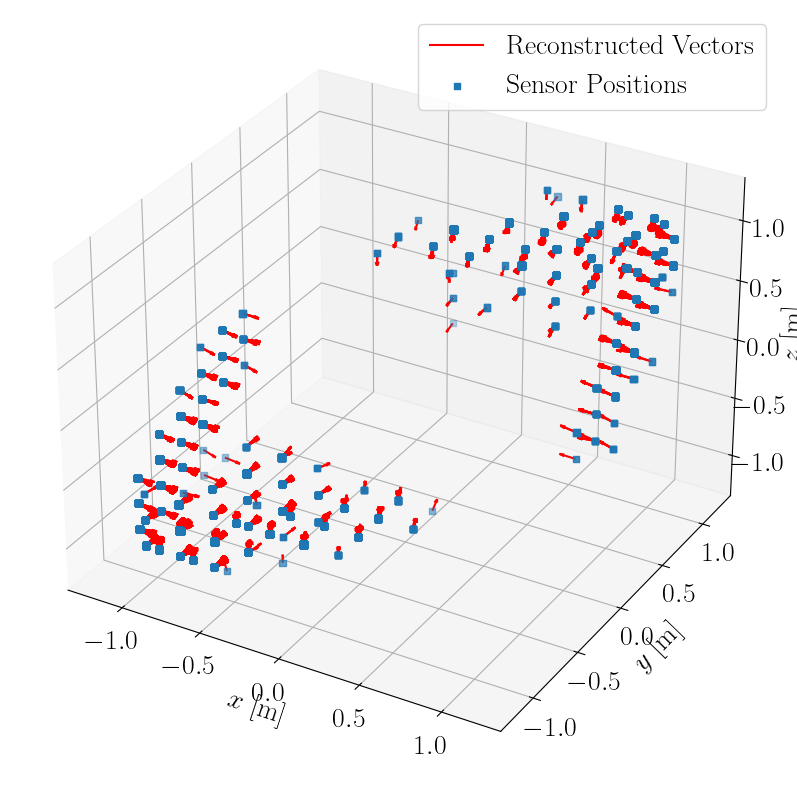

In [13]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
# ax.scatter(df_hits['reconstructedPoint_time'].apply(lambda x: x[0])/1000, 
#            df_hits['reconstructedPoint_time'].apply(lambda x: x[1])/1000, 
#            df_hits['reconstructedPoint_time'].apply(lambda x: x[2])/1000,
#            label='Reconstructed Points')
ax.quiver(df_hits['sensor_position'].apply(lambda x: x[0])/1000, 
          df_hits['sensor_position'].apply(lambda x: x[1])/1000, 
          df_hits['sensor_position'].apply(lambda x: x[2])/1000,
          df_hits['reconstructedVector_direction'].apply(lambda x: x[0]), 
          df_hits['reconstructedVector_direction'].apply(lambda x: x[1]), 
          df_hits['reconstructedVector_direction'].apply(lambda x: x[2]),
          label='Reconstructed Vectors',
          length=0.1,
          normalize=True,
          color='red')
ax.scatter(df_hits['sensor_position'].apply(lambda x: x[0])/1000, 
           df_hits['sensor_position'].apply(lambda x: x[1])/1000, 
           df_hits['sensor_position'].apply(lambda x: x[2])/1000,
           label='Sensor Positions',
           marker='s')
ax.set_xlabel('$x$ [m]')
ax.set_ylabel('$y$ [m]')
ax.set_zlabel('$z$ [m]')
ax.set_xlim(-1.3, 1.3)
ax.set_ylim(-1.3, 1.3)
ax.set_zlim(-1.3, 1.3)
ax.legend()
fig.show()

# Reconstruct Hit With Time

In [14]:
# df_hits['reconstructedVector_time'] = df_hits['reconstructedVector_direction'] * df_hits['time'] * C_XENON_MM_PER_NS

df_hits = make_reconstructedVector_time(df_hits, C_XENON_MM_PER_NS)

# print(df_hits['reconstructedVector_time'])

In [15]:
# df_hits['reconstructedPoint_time'] = df_hits['sensor_position'] + df_hits['reconstructedVector_time']

df_hits = make_reconstructedPoint_time(df_hits)

# print(df_hits['reconstructedPoint_time'])

/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_20977/1246560983.py:28: UserWarning: Matplotlib is currently using pdf, which is a non-GUI backend, so cannot show the figure.
  fig.show()


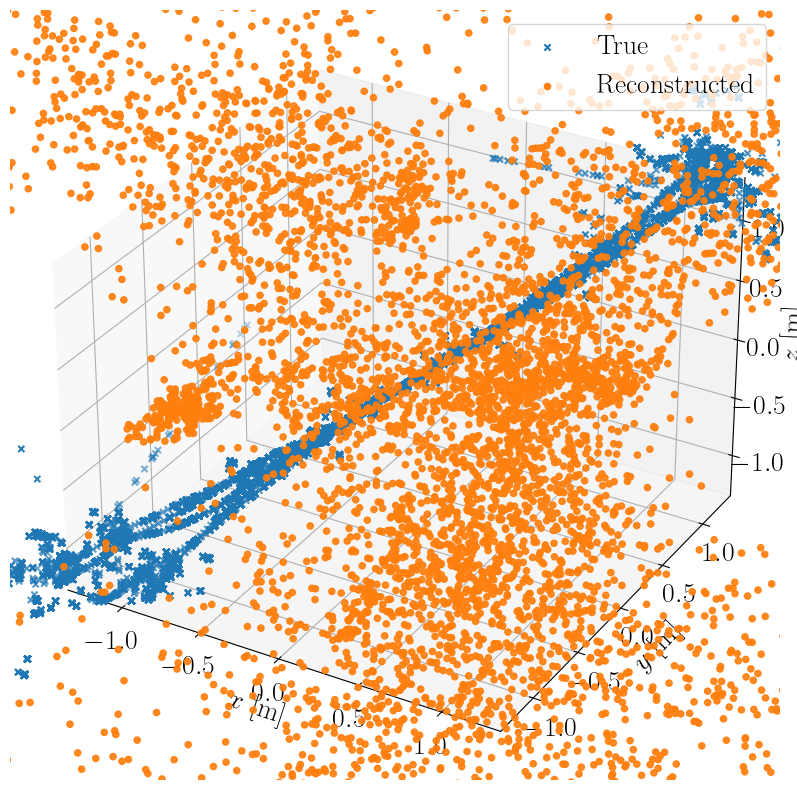

In [16]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_primary['position'].apply(lambda x: x[0])/1000, 
           df_primary['position'].apply(lambda x: x[1])/1000, 
           df_primary['position'].apply(lambda x: x[2])/1000,
           label='True',
           marker='x')
# for i, (sp, rpt) in tqdm.tqdm(enumerate(zip(df_hits['sensor_position'], df_hits['reconstructedPoint_time'])), total=len(df_hits)):
#     ax.quiver(sp[0]/1000, sp[1]/1000, sp[2]/1000,
#               rpt[0]/1000, rpt[1]/1000, rpt[2]/1000,
#               label='Reconstructed Vectors' if i == 0 else None,
#               normalize=True,
#               linewidth=0.5,
#               length=np.linalg.norm(rpt-sp)/1000,
#               alpha=0.02,
#               color='red')
ax.scatter(df_hits['reconstructedPoint_time'].apply(lambda x: x[0])/1000, 
           df_hits['reconstructedPoint_time'].apply(lambda x: x[1])/1000, 
           df_hits['reconstructedPoint_time'].apply(lambda x: x[2])/1000,
           label='Reconstructed')
ax.set_xlabel('$x$ [m]')
ax.set_ylabel('$y$ [m]')
ax.set_zlabel('$z$ [m]')
ax.set_xlim(-1.3, 1.3)
ax.set_ylim(-1.3, 1.3)
ax.set_zlim(-1.3, 1.3)
ax.legend(loc='upper right')
fig.show()

# Reconstruct Hit Ideally with Primary Position

In [17]:
# closestPoints = np.full((max(df_hits.index)+1, 3), -1)
# minDistances = np.full((max(df_hits.index)+1, 1), -1)
# closestPoints = np.full((df_hits.shape[0], 3), -1)
# minDistances = np.full((df_hits.shape[0], 1), -1)
# positions = np.array(df_primary['position'].tolist())
# for i, hit_row in tqdm.tqdm(df_hits.iterrows(), total=df_hits.shape[0]):
#     recoVectorDirection = hit_row['reconstructedVector_direction']
#     sensorPosition = hit_row['sensor_position']

#     vectors = positions - sensorPosition

#     dot_products = np.dot(vectors, recoVectorDirection)
#     projections = dot_products / np.linalg.norm(recoVectorDirection)
#     closest_points_on_line = sensorPosition + projections[:, np.newaxis] * recoVectorDirection
#     distances = np.linalg.norm(closest_points_on_line - positions, axis=1)

#     minDistanceIndex = np.argmin(distances)
#     closestPoints[i] = closest_points_on_line[minDistanceIndex]
#     minDistances[i] = distances[minDistanceIndex]

# # closestPoints = closestPoints[minDistances != -1]
# # minDistances = minDistances[minDistances != -1]
# df_hits['reconstructedPoint_primary_distance'] = closestPoints.tolist()
# df_hits['reconstructedPoint_primary_distance_r'] = minDistances.reshape(-1).tolist()

df_hits = make_reconstructedPoint_primary_distance(df_hits, df_primary)

# print(df_hits['reconstructedPoint_primary_distance'])
# print(df_hits['reconstructedPoint_primary_distance_r'])

100%|██████████| 28106/28106 [01:27<00:00, 320.32it/s]


In [18]:
# furthestPoints = df_hits.nlargest(5, 'reconstructedPoint_primary_distance_r').index

# print(df_hits.loc[furthestPoints]['reconstructedPoint_primary_distance_r'])

/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_20977/3053773788.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


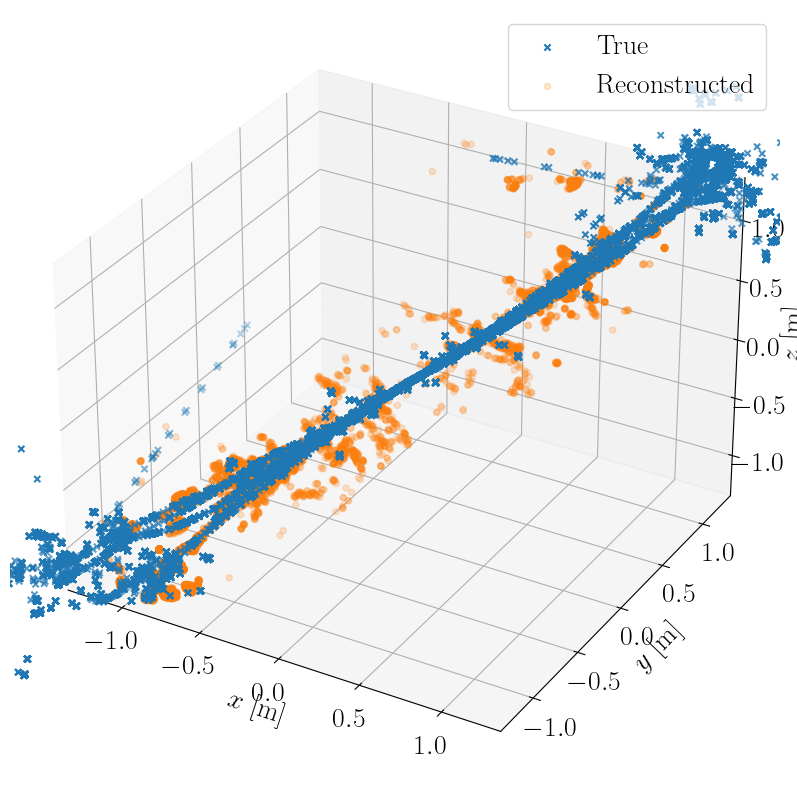

In [19]:
# %matplotlib qt
%matplotlib inline
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_primary['position'].apply(lambda x: x[0])/1000, 
           df_primary['position'].apply(lambda x: x[1])/1000, 
           df_primary['position'].apply(lambda x: x[2])/1000,
           label='True',
           marker='x')
# for i, (sp, rpt) in tqdm.tqdm(enumerate(zip(df_hits['sensor_position'], df_hits['reconstructedPoint_time'])), total=len(df_hits)):
#     ax.quiver(sp[0]/1000, sp[1]/1000, sp[2]/1000,
#               rpt[0]/1000, rpt[1]/1000, rpt[2]/1000,
#               label='Reconstructed Vectors' if i == 0 else None,
#               normalize=True,
#               linewidth=0.5,
#               length=np.linalg.norm(rpt-sp)/1000,
#               alpha=0.02,
#               color='red')
ax.scatter(df_hits['reconstructedPoint_primary_distance'].apply(lambda x: x[0])/1000,
           df_hits['reconstructedPoint_primary_distance'].apply(lambda x: x[1])/1000,
           df_hits['reconstructedPoint_primary_distance'].apply(lambda x: x[2])/1000,
           label='Reconstructed',
           alpha=0.2)
ax.set_xlabel('$x$ [m]')
ax.set_ylabel('$y$ [m]')
ax.set_zlabel('$z$ [m]')
ax.set_xlim(-1.3, 1.3)
ax.set_ylim(-1.3, 1.3)
ax.set_zlim(-1.3, 1.3)
ax.legend(loc='upper right')
fig.show()

mean = 30.45
std = 36.67
1 sigma = 0.98
2 sigma = 0.99
3 sigma = 0.99


/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_20977/3580463661.py:42: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<Figure size 500x500 with 0 Axes>

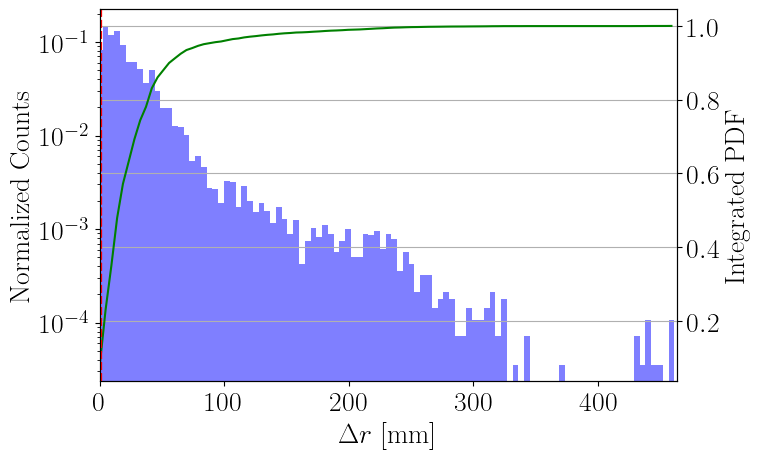

In [20]:
# hist, bins, _ = plt.hist(df_hits['reconstructedPoint_primary_distance_r'], bins=100, alpha=0.5, label='Histogram')
# cumulative_sum = np.cumsum(hist)
# scaled_hist = hist / cumulative_sum[-1]
# plt.clf()

PDF, scaled_hist, bins = get_PDF(df_hits['reconstructedPoint_primary_distance_r'], nBins=100)
primary_mean = np.mean(df_hits['reconstructedPoint_primary_distance_r'])
primary_std = np.std(df_hits['reconstructedPoint_primary_distance_r'])
primary_sigma_1 = get_CSP('1 sigma', PDF, scaled_hist, bins)
primary_sigma_2 = get_CSP('2 sigma', PDF, scaled_hist, bins)
primary_sigma_3 = get_CSP('3 sigma', PDF, scaled_hist, bins)

fig, ax1 = plt.subplots(figsize=(8, 5))
ax1.bar(bins[:-1], scaled_hist, width=np.diff(bins), alpha=0.5, color='blue')
ax1.set_xlabel(r'$\Delta r$ [mm]')
ax1.set_ylabel('Normalized Counts')
ax1.set_yscale('log')
ax1.set_xlim(0, bins[-1])

ax2 = ax1.twinx()
# PDF = cumulative_sum/cumulative_sum[-1]
ax2.plot(bins[:-1], PDF, color='green', label='Histogram')
ax2.set_ylabel('Integrated PDF')

# Add vertical line at 1 sigma
# primary_sigma_1 = bins[np.argmin(np.abs(PDF - 0.6827))]
# primary_sigma_2 = bins[np.argmin(np.abs(PDF - 0.9545))]
# primary_sigma_3 = bins[np.argmin(np.abs(PDF - 0.9973))]
# primary_mean = np.mean(df_hits['reconstructedPoint_primary_distance_r'])
# primary_std = np.std(df_hits['reconstructedPoint_primary_distance_r'])
print('mean = {:.2f}'.format(primary_mean))
print('std = {:.2f}'.format(primary_std))
print('1 sigma = {:.2f}'.format(primary_sigma_1))
print('2 sigma = {:.2f}'.format(primary_sigma_2))
print('3 sigma = {:.2f}'.format(primary_sigma_3))
ax2.axvline(primary_sigma_1, color='red', linestyle='--', label='1 Sigma')
ax2.axvline(primary_sigma_2, color='red', linestyle='--', label='2 Sigma')
ax2.axvline(primary_sigma_3, color='red', linestyle='--', label='3 Sigma')
ax2.grid()

fig.tight_layout()
fig.show()

In [21]:
df_hits['reconstructedPoint_primary_distance_r_x'] = df_hits['reconstructedPoint_primary_distance'].apply(lambda x: x[0]) - df_hits['initialPosition'].apply(lambda x: x[0])
df_hits['reconstructedPoint_primary_distance_r_y'] = df_hits['reconstructedPoint_primary_distance'].apply(lambda x: x[1]) - df_hits['initialPosition'].apply(lambda x: x[1])
df_hits['reconstructedPoint_primary_distance_r_z'] = df_hits['reconstructedPoint_primary_distance'].apply(lambda x: x[2]) - df_hits['initialPosition'].apply(lambda x: x[2])

/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_20977/3342882777.py:42: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<Figure size 500x500 with 0 Axes>

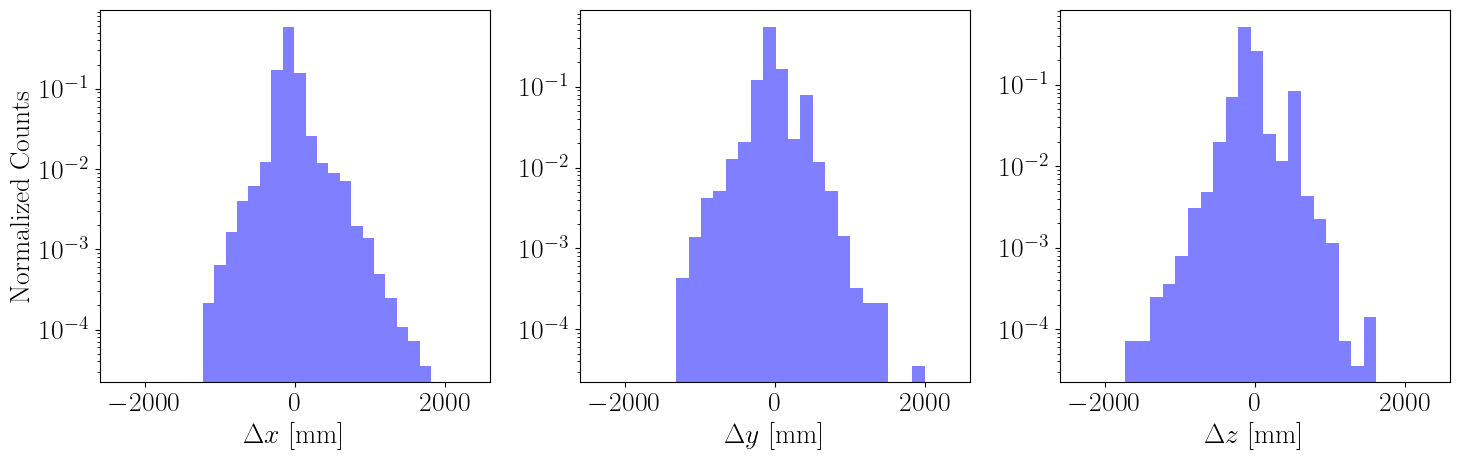

In [23]:
nBins = 20

# hist_x, bins_x, _ = plt.hist(df_hits['reconstructedPoint_primary_distance_r_x'], bins=nBins)
# cumulative_sum_x = np.cumsum(hist_x)
# scaled_hist_x = hist_x / cumulative_sum_x[-1]
# plt.clf()
_, scaled_hist_x, bins_x = get_PDF(df_hits['reconstructedPoint_primary_distance_r_x'], nBins=nBins)

# hist_y, bins_y, _ = plt.hist(df_hits['reconstructedPoint_primary_distance_r_y'], bins=nBins)
# cumulative_sum_y = np.cumsum(hist_y)
# scaled_hist_y = hist_y / cumulative_sum_y[-1]
# plt.clf()
_, scaled_hist_y, bins_y = get_PDF(df_hits['reconstructedPoint_primary_distance_r_y'], nBins=nBins)

# hist_z, bins_z, _ = plt.hist(df_hits['reconstructedPoint_primary_distance_r_z'], bins=nBins)
# cumulative_sum_z = np.cumsum(hist_z)
# scaled_hist_z = hist_z / cumulative_sum_z[-1]
# plt.clf()
_, scaled_hist_z, bins_z = get_PDF(df_hits['reconstructedPoint_primary_distance_r_z'], nBins=nBins)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].bar(bins_x[:-1], scaled_hist_x, width=np.diff(bins_x), alpha=0.5, color='blue')
axes[0].set_xlabel(r'$\Delta x$ [mm]')
axes[0].set_ylabel('Normalized Counts')
axes[0].set_xlim(-2600, 2600)
axes[0].set_yscale('log')

axes[1].bar(bins_y[:-1], scaled_hist_y, width=np.diff(bins_y), alpha=0.5, color='blue')
axes[1].set_xlabel(r'$\Delta y$ [mm]')
# axes[1].set_ylabel('Normalized Counts')
axes[1].set_xlim(-2600, 2600)
axes[1].set_yscale('log')

axes[2].bar(bins_z[:-1], scaled_hist_z, width=np.diff(bins_z), alpha=0.5, color='blue')
axes[2].set_xlabel(r'$\Delta z$ [mm]')
# axes[2].set_ylabel('Normalized Counts')
axes[2].set_xlim(-2600, 2600)
axes[2].set_yscale('log')

fig.tight_layout()
fig.show()

# Reconstruct Hit Ideally with Initial Position

In [24]:
# recoVectorDirections = df_hits['reconstructedVector_direction'].values
# sensorPositions = df_hits['sensor_position'].values
# initialPositions = df_hits['initialPosition'].values

# vectors = np.array([np.array(ip) - np.array(sp) for ip, sp in zip(initialPositions, sensorPositions)])

# dot_products = np.array([np.dot(v, rv) for v, rv in zip(vectors, recoVectorDirections)])
# projections = np.array([ dp / np.linalg.norm(rv) for dp, rv in zip(dot_products, recoVectorDirections)])
# closest_points_on_line = np.array([sp + p * rvd for sp, p, rvd in zip(sensorPositions, projections, recoVectorDirections)])
#     # sensorPosition + projections[:, np.newaxis] * recoVectorDirection
# distances = np.linalg.norm(np.array([cpol - ip for cpol, ip in zip(closest_points_on_line, initialPositions)]), axis=1)

# df_hits['reconstructedPoint_initial_distance'] = closest_points_on_line.tolist()
# df_hits['reconstructedPoint_initial_distance_r'] = distances.tolist()

df_hits = make_reconstructedPoint_initial_distance(df_hits)

In [25]:
furthestPoints = df_hits.nlargest(5, 'reconstructedPoint_initial_distance_r').index
# print(df_hits.loc[furthestPoints]['reconstructedPoint_initial_distance_r'])

/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_20977/3488627808.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


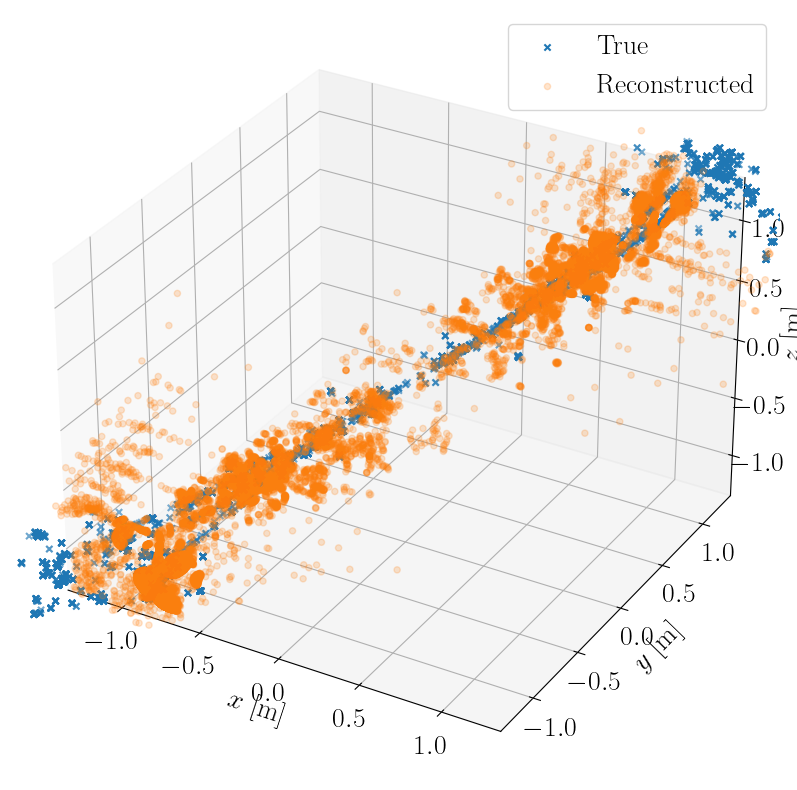

In [26]:
# %matplotlib qt
%matplotlib inline
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_hits['initialPosition'].apply(lambda x: x[0])/1000, 
           df_hits['initialPosition'].apply(lambda x: x[1])/1000, 
           df_hits['initialPosition'].apply(lambda x: x[2])/1000,
           label='True',
           marker='x')
# for i, (sp, rpt) in tqdm.tqdm(enumerate(zip(df_hits['sensor_position'], df_hits['reconstructedPoint_time'])), total=len(df_hits)):
#     ax.quiver(sp[0]/1000, sp[1]/1000, sp[2]/1000,
#               rpt[0]/1000, rpt[1]/1000, rpt[2]/1000,
#               label='Reconstructed Vectors' if i == 0 else None,
#               normalize=True,
#               linewidth=0.5,
#               length=np.linalg.norm(rpt-sp)/1000,
#               alpha=0.02,
#               color='red')
ax.scatter(df_hits['reconstructedPoint_initial_distance'].apply(lambda x: x[0])/1000,
           df_hits['reconstructedPoint_initial_distance'].apply(lambda x: x[1])/1000,
           df_hits['reconstructedPoint_initial_distance'].apply(lambda x: x[2])/1000,
           label='Reconstructed',
           alpha=0.2)
ax.set_xlabel('$x$ [m]')
ax.set_ylabel('$y$ [m]')
ax.set_zlabel('$z$ [m]')
ax.set_xlim(-1.3, 1.3)
ax.set_ylim(-1.3, 1.3)
ax.set_zlim(-1.3, 1.3)
ax.legend(loc='upper right')
fig.show()

mean = 133.33
std = 157.21
1 sigma = 0.98
2 sigma = 0.99
3 sigma = 0.99


/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_20977/3913290164.py:41: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<Figure size 500x500 with 0 Axes>

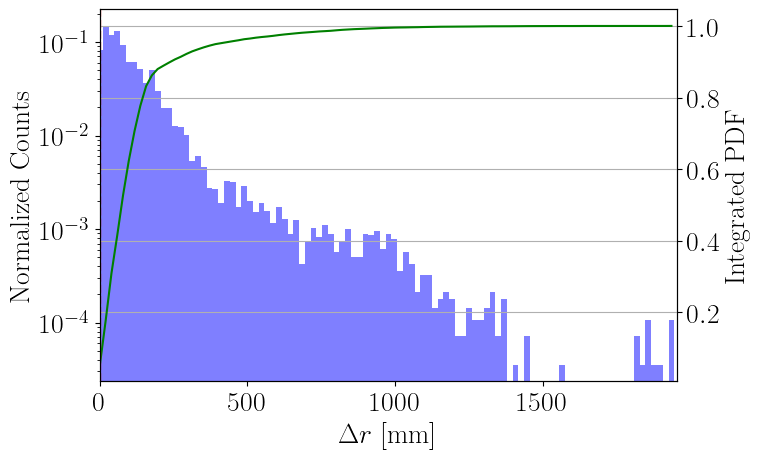

In [27]:
# hist, bins, _ = plt.hist(df_hits['reconstructedPoint_initial_distance_r'], bins=100, alpha=0.5, label='Histogram')
# cumulative_sum = np.cumsum(hist)
# scaled_hist = hist / cumulative_sum[-1]
# plt.clf()
PDF, hist, bins = get_PDF(df_hits['reconstructedPoint_initial_distance_r'], nBins=100)
initial_mean = np.mean(df_hits['reconstructedPoint_initial_distance_r'])
initial_std = np.std(df_hits['reconstructedPoint_initial_distance_r'])
initial_sigma_1 = get_CSP('1 sigma', PDF, hist, bins)
initial_sigma_2 = get_CSP('2 sigma', PDF, hist, bins)
initial_sigma_3 = get_CSP('3 sigma', PDF, hist, bins)

fig, ax1 = plt.subplots(figsize=(8, 5))
ax1.bar(bins[:-1], scaled_hist, width=np.diff(bins), alpha=0.5, color='blue')
ax1.set_xlabel(r'$\Delta r$ [mm]')
ax1.set_ylabel('Normalized Counts')
ax1.set_yscale('log')
ax1.set_xlim(0, bins[-1])

ax2 = ax1.twinx()
# PDF = cumulative_sum/cumulative_sum[-1]
ax2.plot(bins[:-1], PDF, color='green', label='Histogram')
ax2.set_ylabel('Integrated PDF')

# Add vertical line at 1 sigma
# initial_sigma_1 = bins[np.argmin(np.abs(PDF - 0.6827))]
# initial_sigma_2 = bins[np.argmin(np.abs(PDF - 0.9545))]
# initial_sigma_3 = bins[np.argmin(np.abs(PDF - 0.9973))]
# initial_mean = np.mean(df_hits['reconstructedPoint_initial_distance_r'])
# initial_std = np.std(df_hits['reconstructedPoint_initial_distance_r'])
print('mean = {:.2f}'.format(initial_mean))
print('std = {:.2f}'.format(initial_std))
print('1 sigma = {:.2f}'.format(initial_sigma_1))
print('2 sigma = {:.2f}'.format(initial_sigma_2))
print('3 sigma = {:.2f}'.format(initial_sigma_3))
ax2.axvline(initial_sigma_1, color='red', linestyle='--', label='1 Sigma')
ax2.axvline(initial_sigma_2, color='red', linestyle='--', label='2 Sigma')
ax2.axvline(initial_sigma_3, color='red', linestyle='--', label='3 Sigma')
ax2.grid()

fig.tight_layout()
fig.show()

In [28]:
df_hits['reconstructedPoint_initial_distance_r_x'] = df_hits['reconstructedPoint_initial_distance'].apply(lambda x: x[0]) - df_hits['initialPosition'].apply(lambda x: x[0])
df_hits['reconstructedPoint_initial_distance_r_y'] = df_hits['reconstructedPoint_initial_distance'].apply(lambda x: x[1]) - df_hits['initialPosition'].apply(lambda x: x[1])
df_hits['reconstructedPoint_initial_distance_r_z'] = df_hits['reconstructedPoint_initial_distance'].apply(lambda x: x[2]) - df_hits['initialPosition'].apply(lambda x: x[2])

/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_20977/2262005595.py:42: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<Figure size 500x500 with 0 Axes>

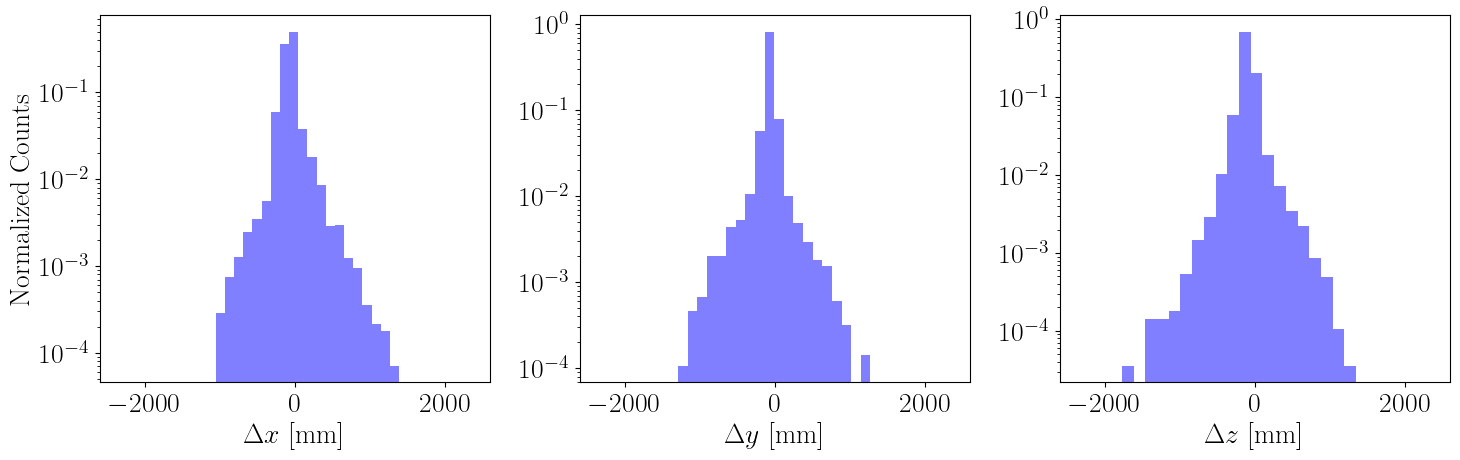

In [31]:
nBins = 20

# hist_x, bins_x, _ = plt.hist(df_hits['reconstructedPoint_initial_distance_r_x'], bins=nBins)
# cumulative_sum_x = np.cumsum(hist_x)
# scaled_hist_x = hist_x / cumulative_sum_x[-1]
# plt.clf()
_, scaled_hist_x, bins_x = get_PDF(df_hits['reconstructedPoint_initial_distance_r_x'], nBins=nBins)

# hist_y, bins_y, _ = plt.hist(df_hits['reconstructedPoint_initial_distance_r_y'], bins=nBins)
# cumulative_sum_y = np.cumsum(hist_y)
# scaled_hist_y = hist_y / cumulative_sum_y[-1]
# plt.clf()
_, scaled_hist_y, bins_y = get_PDF(df_hits['reconstructedPoint_initial_distance_r_y'], nBins=nBins)

# hist_z, bins_z, _ = plt.hist(df_hits['reconstructedPoint_initial_distance_r_z'], bins=nBins)
# cumulative_sum_z = np.cumsum(hist_z)
# scaled_hist_z = hist_z / cumulative_sum_z[-1]
# plt.clf()
_, scaled_hist_z, bins_z = get_PDF(df_hits['reconstructedPoint_initial_distance_r_z'], nBins=nBins)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].bar(bins_x[:-1], scaled_hist_x, width=np.diff(bins_x), alpha=0.5, color='blue')
axes[0].set_xlabel(r'$\Delta x$ [mm]')
axes[0].set_ylabel('Normalized Counts')
axes[0].set_xlim(-2600, 2600)
axes[0].set_yscale('log')

axes[1].bar(bins_y[:-1], scaled_hist_y, width=np.diff(bins_y), alpha=0.5, color='blue')
axes[1].set_xlabel(r'$\Delta y$ [mm]')
# axes[1].set_ylabel('Normalized Counts')
axes[1].set_xlim(-2600, 2600)
axes[1].set_yscale('log')

axes[2].bar(bins_z[:-1], scaled_hist_z, width=np.diff(bins_z), alpha=0.5, color='blue')
axes[2].set_xlabel(r'$\Delta z$ [mm]')
# axes[2].set_ylabel('Normalized Counts')
axes[2].set_xlim(-2600, 2600)
axes[2].set_yscale('log')

fig.tight_layout()
fig.show()

# Performance Reconstruction Methods With Respect to Filter Parameters

In [34]:
print(search_radius)
print(search_number)
print('{:.2f}'.format(np.mean(df_hits['reconstructedPoint_primary_distance_r'])))
print('{:.2f}'.format(np.std(df_hits['reconstructedPoint_primary_distance_r'])))
print('{:.2f}'.format(primary_sigma_1))
print('{:.2f}'.format(primary_sigma_2))
print('{:.2f}'.format(primary_sigma_3))
print('{:.2f}'.format(np.mean(df_hits['reconstructedPoint_initial_distance_r'])))
print('{:.2f}'.format(np.std(df_hits['reconstructedPoint_initial_distance_r'])))
print('{:.2f}'.format(initial_sigma_1))
print('{:.2f}'.format(initial_sigma_2))
print('{:.2f}'.format(initial_sigma_3))
print()
print('[{:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}]'
        .format(search_radius, search_number, primary_mean, primary_std, primary_sigma_1, primary_sigma_2, primary_sigma_3, initial_mean, initial_std, initial_sigma_1, initial_sigma_2, initial_sigma_3))

3
3
29.68
34.70
0.98
0.99
0.99
127.89
147.51
0.98
0.99
0.99

[3.00, 3.00, 30.45, 36.67, 0.98, 0.99, 0.99, 133.33, 157.21, 0.98, 0.99, 0.99]
